In the learning process were used next models: *Logistic Regression*, *RandomForest Classifier*, *CatBoost Classifier*. <br>
Finally these models were stacked into one stacking model.
### SUBMISSION SCORE: 0.85150

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from catboost import CatBoostClassifier

c:\Users\Solega\miniconda3\envs\datascience\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



### Loading

In [2]:
data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### Preprocessing 
Column TotalSpent contained 'space' values for the newbie customers. That's why I replaced these rows with the 0 values in order to convert it to the float type. \
According to the 'churn' barplot the second class is 4 times greater than the first one. This means that people are four times more likely to stay than to leave. \
The categorical features were converted to int type according to the next observations:
<ul>
    <li>values «No internet service» and «No Phone service» are redudant
    <li>in the payment method column the only relevant is whether the payment is made automatically or not
    <li>the difference between electronic check and other payment methods is much significant than between automatic and non-automatic
    <li>people with long-term phone contracts are reluctant to terminate
    <li>people with optics are more often unsatisfied with provider serivces than DSL users
    <li>new users are more inclined to churn with peak in the first month; regular customers remain faithful to the habits

In [4]:
num_cols = [
    "ClientPeriod",
    "MonthlySpending",
    "TotalSpent",
]

cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

target = 'Churn'

In [5]:
data.replace(' ', np.nan, inplace=True)
X_test.replace(' ', np.nan, inplace=True)
data.TotalSpent = data.TotalSpent.fillna(0).astype('float64')
X_test.TotalSpent = X_test.TotalSpent.fillna(0).astype('float64')

### Visualising

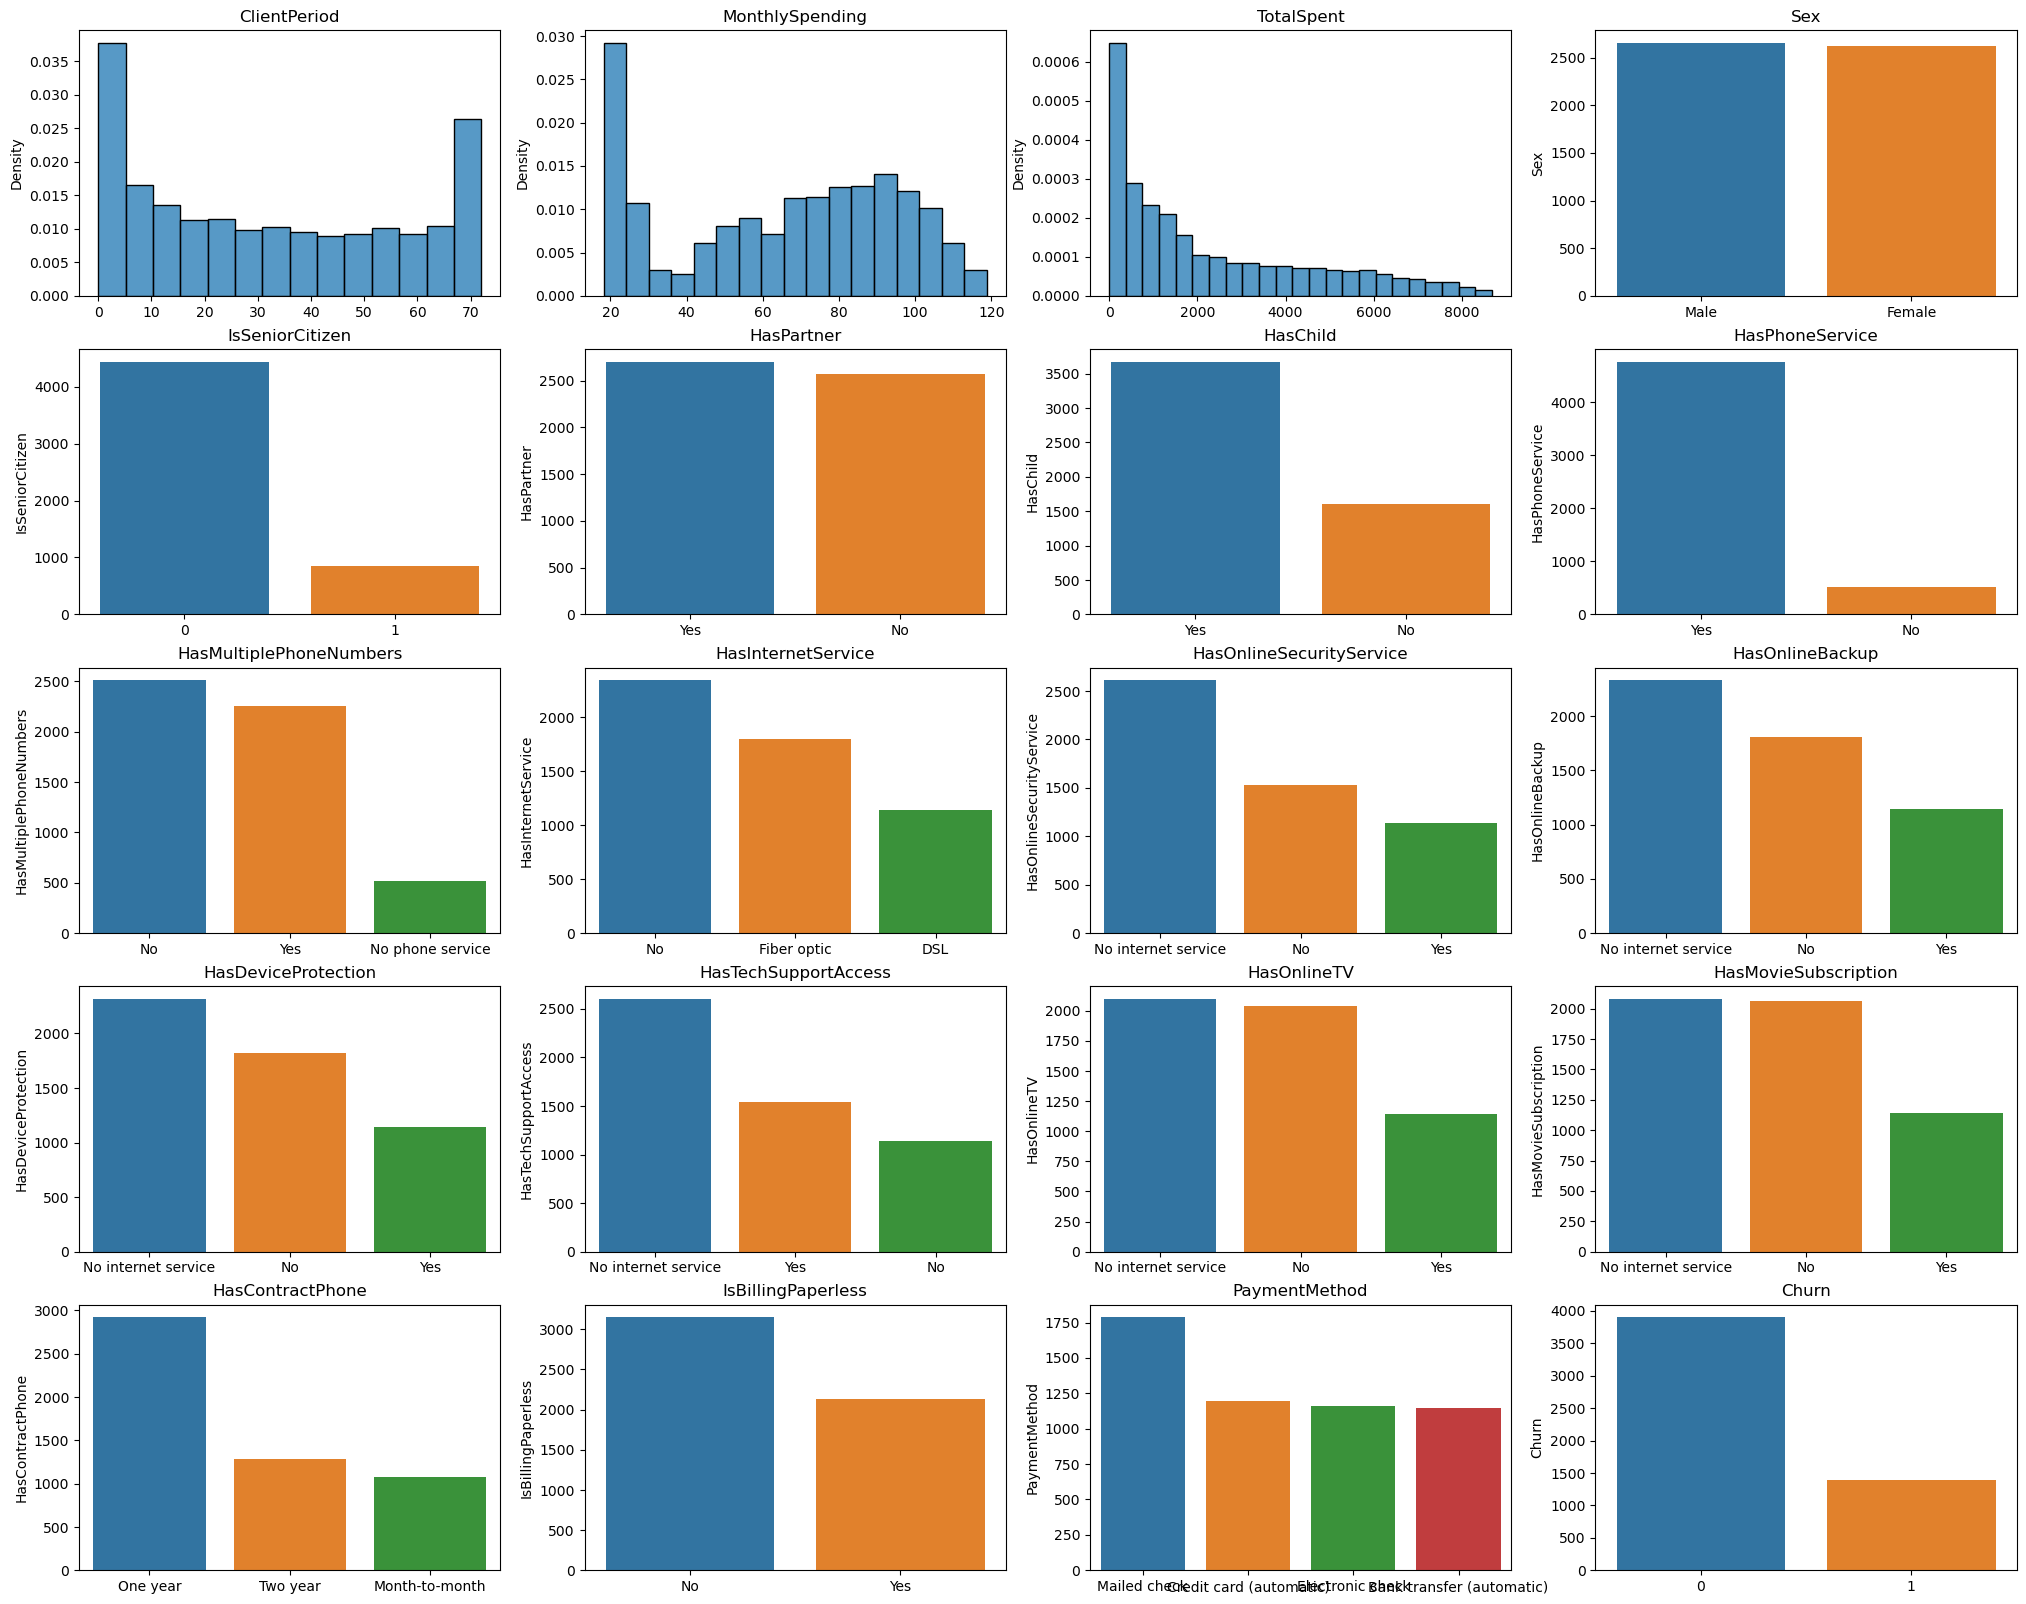

In [6]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))

for ax, col in zip(axes.flatten(), data.columns):
    ax.set_title(col)
    
    if col in cat_cols or col == target:
        sns.barplot(ax=ax, x=data[col].unique(), y=data[col].value_counts())
        # ax.pie(data[col].value_counts(), autopct="%1.1f%%", labels=data[col].value_counts().index)
    else:
        sns.histplot(ax=ax, x=data[col].values, stat='density')

In [7]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}

X_train = data.replace(patterns).drop(target, axis=1)
y_train = data[target]

X_test = X_test.replace(patterns)


### Linear model
**best score:** *0.8454* \
**best parameter:** *C = 100*

In [8]:
params = {
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001]
}

clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42)),
])

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=10,
    refit=True
)

logreg = grid_search.fit(X_train, y_train)

In [9]:
print(f'best score: {logreg.best_score_}')
print(f'best params: {logreg.best_params_}')

best score: 0.8454220892014195
best params: {'model__C': 100}


### Random Forest
**Best score:** *0.8440515744758083* \
**Best params:** *max_depth: 5, min_samples_split: 2, n_estimators: 500*

In [10]:
clf = RandomForestClassifier()

param_grid = [
        {'n_estimators': [10, 100, 200, 500], 'max_depth': [None, 5, 10], 'min_samples_split': [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')
rf = grid_search.fit(X_train, y_train)


In [11]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.8442221194581065
Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


### Boosting
**best score:** *0.8642032782485164* <br>
**best params:** *n_estimators: 250, max_depth: 5, min_data_in_leaf: 1000*

In [12]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=0,
    learning_rate=0.05,
    subsample=0.6,
    random_strength=5,
    l2_leaf_reg=10
)

grid_params = {
    "n_estimators": [200, 250, 300],
    "max_depth": np.arange(3, 8, 1),
    "min_data_in_leaf": [10, 100, 1000],  
}
catboost.grid_search(grid_params, X_train, y_train, cv=5, plot=True, refit=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8697481	best: 0.8697481 (0)	total: 3.36s	remaining: 2m 28s
1:	loss: 0.8696525	best: 0.8697481 (0)	total: 7.38s	remaining: 2m 38s
2:	loss: 0.8686662	best: 0.8697481 (0)	total: 11.8s	remaining: 2m 45s
3:	loss: 0.8685491	best: 0.8697481 (0)	total: 16.3s	remaining: 2m 46s
4:	loss: 0.8683557	best: 0.8697481 (0)	total: 21.8s	remaining: 2m 54s
5:	loss: 0.8670182	best: 0.8697481 (0)	total: 28.5s	remaining: 3m 5s
6:	loss: 0.8712551	best: 0.8712551 (6)	total: 35.2s	remaining: 3m 11s
7:	loss: 0.8696597	best: 0.8712551 (6)	total: 43.5s	remaining: 3m 21s
8:	loss: 0.8682530	best: 0.8712551 (6)	total: 53.5s	remaining: 3m 33s
9:	loss: 0.8680667	best: 0.8712551 (6)	total: 1m 3s	remaining: 3m 40s
10:	loss: 0.8672881	best: 0.8712551 (6)	total: 1m 14s	remaining: 3m 51s
11:	loss: 0.8646586	best: 0.8712551 (6)	total: 1m 29s	remaining: 4m 6s
12:	loss: 0.8698627	best: 0.8712551 (6)	total: 1m 41s	remaining: 4m 9s
13:	loss: 0.8662993	best: 0.8712551 (6)	total: 1m 56s	remaining: 4m 16s
14:	loss: 0.864

In [13]:
print("Best score:", end=' ')
pprint(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
pprint(best_params)

Best score: {'learn': {'AUC': 0.8544107582960878, 'Logloss': 0.4035890436083869}}
Best params: {'depth': 5,
 'grow_policy': 'Lossguide',
 'iterations': 200,
 'l2_leaf_reg': 10,
 'learning_rate': 0.05,
 'metric_period': 1000,
 'min_data_in_leaf': 1000,
 'random_seed': 0,
 'random_strength': 5,
 'subsample': 0.6}


### Stacking

In [14]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)

stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        ("catboost", catboost),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train);

### Submission

In [15]:
best_model = stacking

In [16]:
y_pred = best_model.predict_proba(X_test)[:, 1]
submission = pd.read_csv('submission.csv')
submission.Churn = y_pred
submission.to_csv('my_sub.csv', index=False)